In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import xarray as xr
import glob
import pyart
import cartopy.crs as ccrs
import zipfile
import warnings
import os
import matplotlib.pyplot as plt
import h5py
import netCDF4 as nc
import matplotlib
import shapely
from cartopy import geodesic
warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def plot_range_rings(lon, lat, r, ax, color="k"):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=1)

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]


def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143.047172267468; max_lon=146.463827732532; min_lat=-39.2042830440922; max_lat=-36.5063169559078
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149.588054873546; max_lon=152.830745126454; min_lat=-35.0497830440922; max_lat=-32.3518169559078
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151.016761314807; max_lon=154.061238685193; min_lat=-28.9569830440922; max_lat=-26.2590169559078
    elif rid=="66":
        min_lon=151.716232124553; max_lon=154.763767875447; min_lat=-29.0667830440922; max_lat=-26.3688169559078
    elif rid=="28":
        min_lon=151.5; max_lon=154.5; min_lat=-31; max_lat=-28.5     
    elif rid=="4":
        min_lon=150.5; max_lon=153; min_lat=-34; max_lat=-32
    elif rid=="55":
        min_lon=146; max_lon=149; min_lat=-36.5; max_lat=-34            
    elif rid=="27":
        min_lon=135.226736433275; max_lon=138.379263566725; min_lat=-32.5059830440922; max_lat=-29.8080169559078    
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="^", mew=2, ms=10, color="lightgray", mec="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (dBZ)",fontsize=14)
        cb.ax.tick_params(labelsize=14)

    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    if (rid=="27") | (rid=="50"):
        times = [time+dt.timedelta(seconds=-60*10), time+dt.timedelta(seconds=30)]
    else:
        times = [time+dt.timedelta(seconds=-60*6), time+dt.timedelta(seconds=30)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]   
    
    radar_file = pyart.io.read_grid(target_files[-1])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file   

def cape_shear_data(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        #subset = f.isel_points("points",lat=a, lon=b)
        subset=f.isel(lat=xr.DataArray(a, dims="points"), lon=xr.DataArray(b, dims="points"))
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)

def reconstruct_grid(f, group_id):

        #From h5 grid objects (f), reconstruct the radar grid

        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]

        return recon, x, y
    
def plot_driver(dets, save_name):
    
    letters = ["a","b","c","d","e","f","g","h","i"]
    
    plt.figure(figsize=[16,16])

    cnt=1
    for index, row in dets.iterrows():

        print(row.gust_time_utc)
        ax = plt.subplot(3,3,cnt,projection=ccrs.PlateCarree())
        if cnt==1:
            plot_cbar=True
        else:
            plot_cbar=False
        disp = plot_radar(row.rid, row.gust_time_utc, row.lon, row.lat, ax, plot_cbar=plot_cbar)        
        g1=ax.gridlines(draw_labels=True); g1.ylabels_right=False; g1.xlabels_top=False
        ax.coastlines()

        t1 = (row.gust_time_utc+dt.timedelta(hours=-12)).strftime("%Y%m%d")
        t2 = (row.gust_time_utc+dt.timedelta(hours=+12)).strftime("%Y%m%d")    
        grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+\
                         row.rid + "_" + t1 + "_" + t2 + ".h5", "r")
        print("/g/data/eg3/ab4502/TINTobjects/"+\
                         row.rid + "_" + t1 + "_" + t2 + ".h5")

        group_id = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+row.rid + "_" + t1 + "_" + t2 + "_aws.csv")\
                            .query("(uid10=="+str(row.uid)+") & (scan=="+str(row.scan)+")").group_id.iloc[0]
        group_id = group_id.split("/")[0]+"/"+str(int(row.uid))

        mask, x, y = reconstruct_grid(grid, group_id)
        ax.contour(x,y,mask,levels=[0,1],colors="k",edgewidths=5)

        plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],150,ax,color="gray")
        plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],100,ax,color="gray")
        plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],50,ax,color="gray")
        g1.ylabel_style = {"size":14}
        g1.xlabel_style = {"size":14}   
        ax.plot(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],marker="+",ms=14,mew=1,color="k")

        ax.set_title(letters[cnt-1] + ") " + disp.grid.to_xarray().time.values[0].strftime("%Y-%m-%d %H:%M") + " UTC")   

        cnt=cnt+1

    plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/"+save_name+".jpeg", quality=100, bbox_inches="tight")    

In [3]:
details_list = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details_list["gust_time_utc"] = pd.DatetimeIndex(details_list.gust_time_utc)
details_list["rid"] = details_list.rid.astype(str)
details_list["stn_id"] = details_list.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

2006-09-24 01:44:00
/g/data/eg3/ab4502/TINTobjects/2_20060923_20060924.h5
2009-11-20 03:06:00
/g/data/eg3/ab4502/TINTobjects/2_20091119_20091120.h5
2010-03-06 03:30:00
/g/data/eg3/ab4502/TINTobjects/2_20100305_20100306.h5
2010-06-17 00:24:00
/g/data/eg3/ab4502/TINTobjects/2_20100616_20100617.h5
2011-11-18 07:04:00
/g/data/eg3/ab4502/TINTobjects/2_20111117_20111118.h5
2011-12-25 06:45:00
/g/data/eg3/ab4502/TINTobjects/2_20111224_20111225.h5
2012-02-26 09:11:00
/g/data/eg3/ab4502/TINTobjects/2_20120225_20120226.h5
2015-02-28 09:25:00
/g/data/eg3/ab4502/TINTobjects/2_20150227_20150228.h5
2017-12-19 08:50:00
/g/data/eg3/ab4502/TINTobjects/2_20171218_20171219.h5


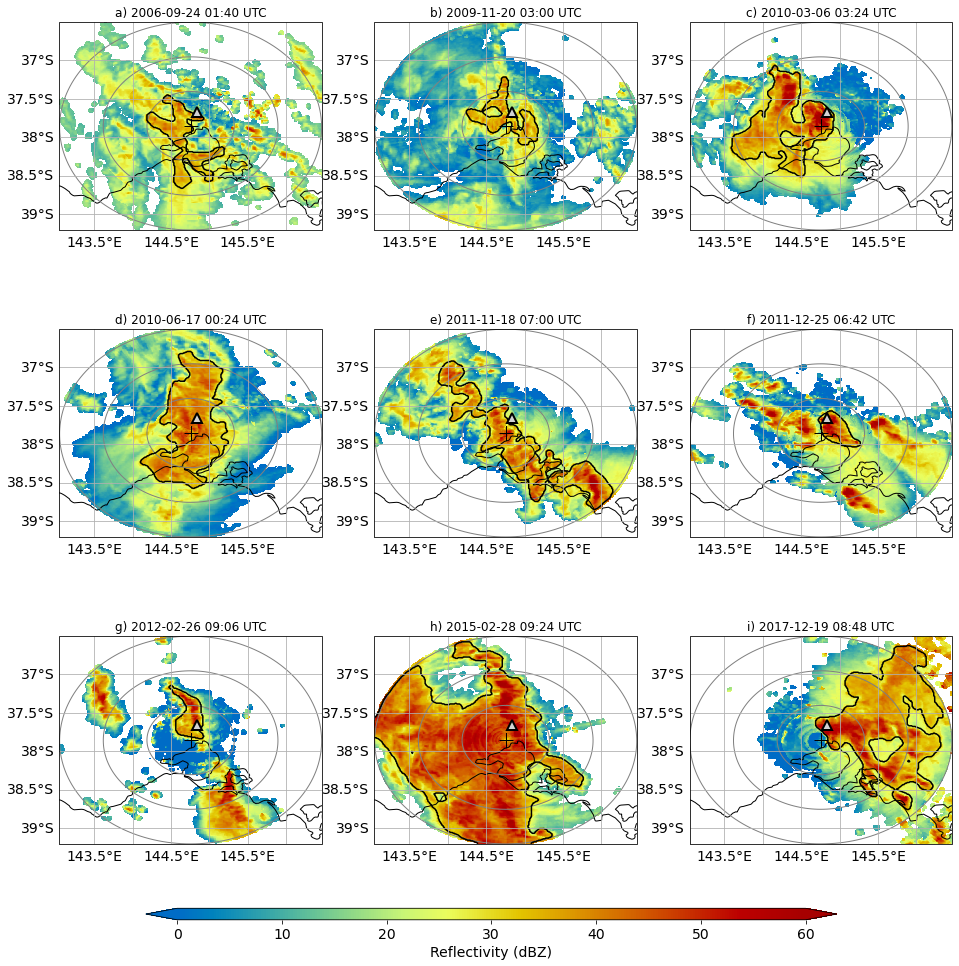

In [5]:
plot_driver(details_list[details_list.stn_name=="Melbourne"], "cape_s06_radar_vic")

2010-08-02 15:43:00
/g/data/eg3/ab4502/TINTobjects/71_20100802_20100803.h5
2012-08-10 04:21:00
/g/data/eg3/ab4502/TINTobjects/71_20120809_20120810.h5
2013-02-23 13:43:00
/g/data/eg3/ab4502/TINTobjects/71_20130223_20130224.h5
2014-10-14 11:39:00
/g/data/eg3/ab4502/TINTobjects/71_20141013_20141014.h5
2015-03-01 04:34:00
/g/data/eg3/ab4502/TINTobjects/71_20150228_20150301.h5
2015-12-16 02:03:00
/g/data/eg3/ab4502/TINTobjects/71_20151215_20151216.h5
2016-01-14 04:20:00
/g/data/eg3/ab4502/TINTobjects/71_20160113_20160114.h5
2016-06-04 03:42:00
/g/data/eg3/ab4502/TINTobjects/71_20160603_20160604.h5
2017-04-09 08:03:00
/g/data/eg3/ab4502/TINTobjects/71_20170408_20170409.h5


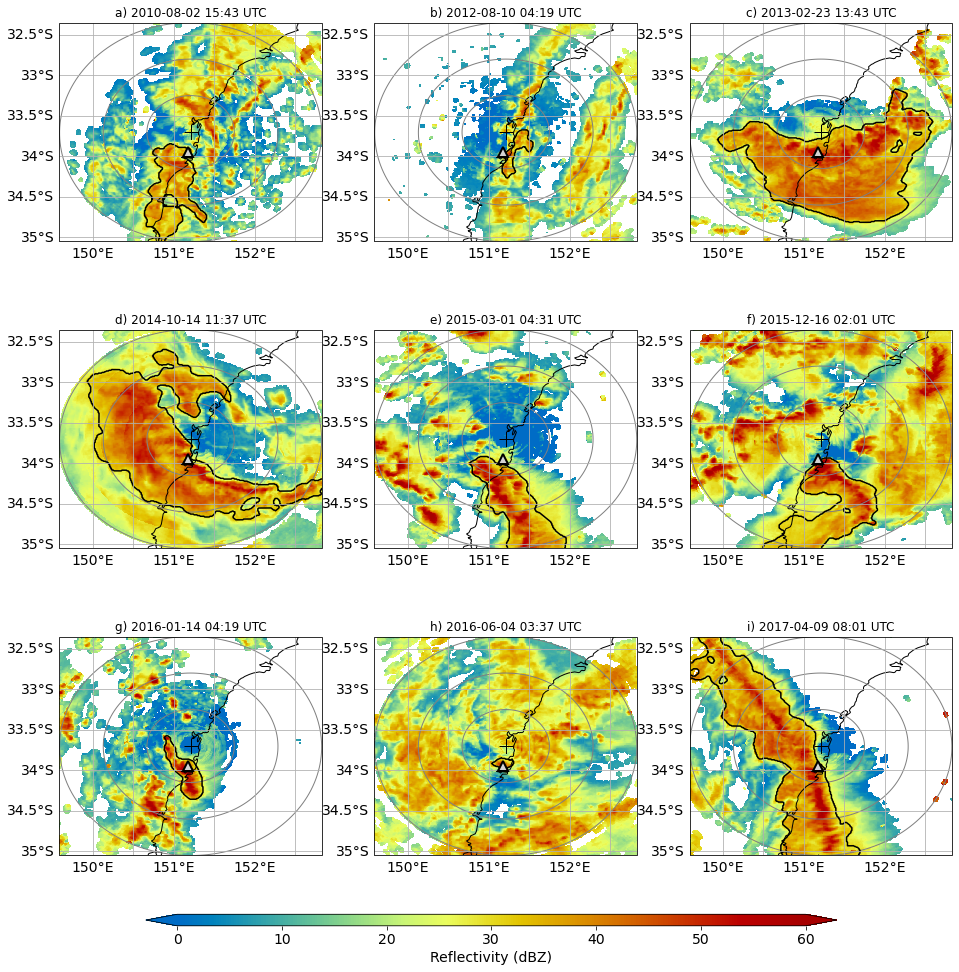

In [6]:
plot_driver(details_list[details_list.stn_name=="Sydney"], "cape_s06_radar_nsw")

2010-12-16 03:25:00
/g/data/eg3/ab4502/TINTobjects/66_20101215_20101216.h5
2011-01-18 05:05:00
/g/data/eg3/ab4502/TINTobjects/66_20110117_20110118.h5
2011-10-07 19:30:00
/g/data/eg3/ab4502/TINTobjects/50_20111007_20111008.h5
2013-10-18 04:04:00
/g/data/eg3/ab4502/TINTobjects/50_20131017_20131018.h5
2013-11-23 09:45:00
/g/data/eg3/ab4502/TINTobjects/66_20131122_20131123.h5
2014-01-23 05:00:00
/g/data/eg3/ab4502/TINTobjects/50_20140122_20140123.h5
2016-01-29 04:22:00
/g/data/eg3/ab4502/TINTobjects/50_20160128_20160129.h5
2016-12-18 04:14:00
/g/data/eg3/ab4502/TINTobjects/66_20161217_20161218.h5
2018-02-13 07:05:00
/g/data/eg3/ab4502/TINTobjects/50_20180212_20180213.h5


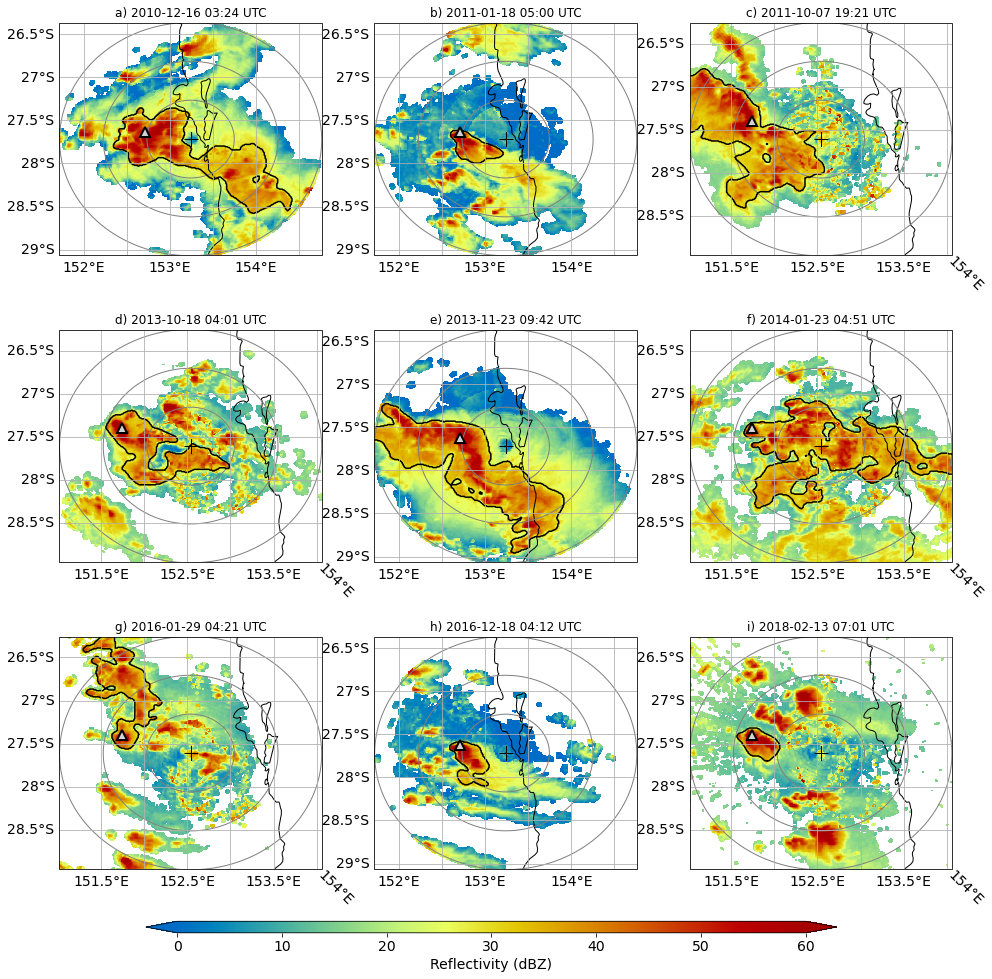

In [7]:
plot_driver(details_list[(details_list.stn_name=="Amberley") | ((details_list.stn_name=="Oakey"))].sort_values("gust_time_utc"), "cape_s06_radar_qld")

2007-10-27 09:03:00
/g/data/eg3/ab4502/TINTobjects/27_20071026_20071027.h5
2008-12-09 06:18:00
/g/data/eg3/ab4502/TINTobjects/27_20081208_20081209.h5
2010-12-07 09:27:00
/g/data/eg3/ab4502/TINTobjects/27_20101206_20101207.h5
2011-11-08 09:47:00
/g/data/eg3/ab4502/TINTobjects/27_20111107_20111108.h5
2012-01-29 04:42:00
/g/data/eg3/ab4502/TINTobjects/27_20120128_20120129.h5
2012-11-30 08:33:00
/g/data/eg3/ab4502/TINTobjects/27_20121129_20121130.h5
2014-10-31 07:52:00
/g/data/eg3/ab4502/TINTobjects/27_20141030_20141031.h5
2015-12-07 11:20:00
/g/data/eg3/ab4502/TINTobjects/27_20151206_20151207.h5
2017-12-18 11:34:00
/g/data/eg3/ab4502/TINTobjects/27_20171217_20171218.h5


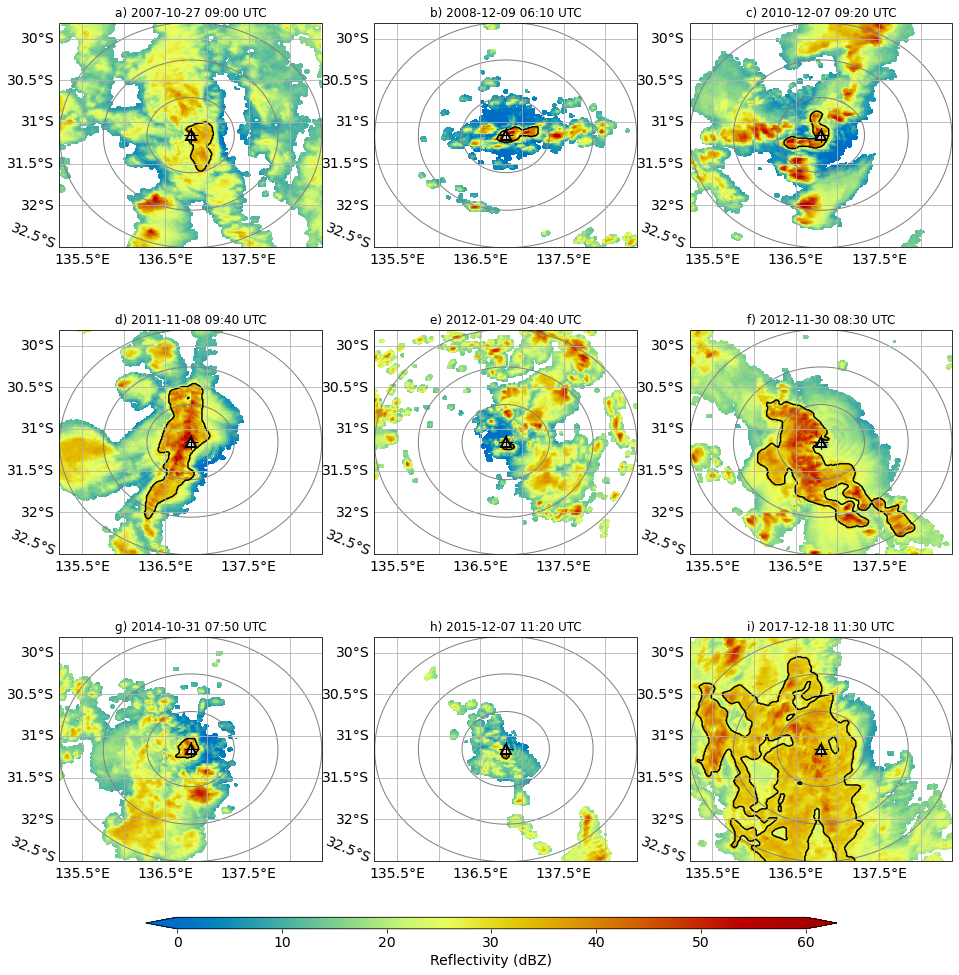

In [8]:
plot_driver(details_list[details_list.stn_name=="Woomera"], "cape_s06_radar_sa")

a) 
b) 
c) 


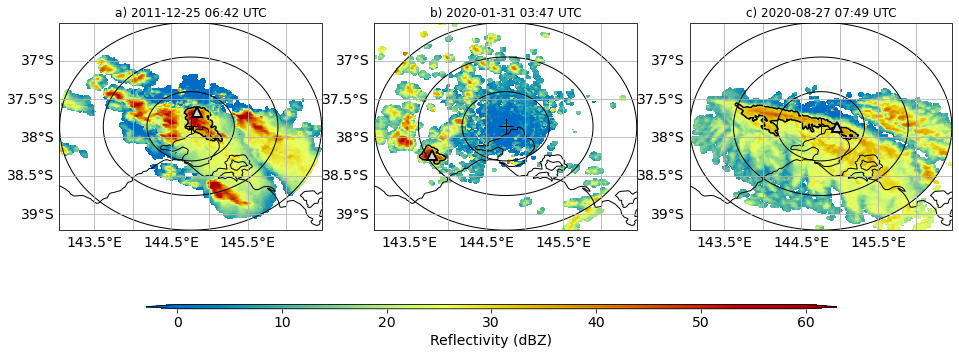

In [5]:
#Three cases for Melbourne: All didderent environmental clusters

plt.figure(figsize=[16,6])

dets = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,42)], "rid":"2", "title":"a) "},\
        {"lat":-38.2332, "lon":143.7924, "time" : [dt.datetime(2020,1,31,3,47,0)], "rid":"2", "title":"b) "},\
        {"lat":-37.8640, "lon":144.9639, "time" : [dt.datetime(2020,8,27,7,49,0)], "rid":"2", "title":"c) "},\
       ]
, 
cnt=1
cape_list=[]
s06_list=[]

grids = [h5py.File("/g/data/eg3/ab4502/TINTobjects/2_20111201_20111231.h5", "r"),\
         h5py.File("/g/data/eg3/ab4502/TINTobjects/2_20200101_20200131.h5", "r"),\
         h5py.File("/g/data/eg3/ab4502/TINTobjects/2_20200801_20200831.h5", "r")]
group_ids = ["20111225063636/1267","20200131034228/1904","20200827074831/508"]

for i in np.arange(len(dets)):
    print(dets[i]["title"])
    ax = plt.subplot(1,3,cnt,projection=ccrs.PlateCarree())
    plt.title(dets[i]["title"] + dets[i]["time"][0].strftime("%Y-%m-%d %H:%M") + " UTC")   
    if cnt==1:
        plot_cbar=True
    else:
        plot_cbar=False
    disp = plot_radar(dets[i]["rid"], dets[i]["time"][0], dets[i]["lon"], dets[i]["lat"], ax, plot_cbar=plot_cbar)        
    g1=ax.gridlines(draw_labels=True); g1.ylabels_right=False; g1.xlabels_top=False
    ax.coastlines()
    
    t = dets[i]["time"][0].strftime("%Y%m%d")
    grid = grids[i]
    group_id = group_ids[i]
    
    mask, x, y = reconstruct_grid(grid, group_id)
    ax.contour(x,y,mask,levels=[0,1],colors="k")
    
    temp_df = cape_shear_data(["mu_cape","s06"], dets[i]["time"][0], dets[i]["lat"], dets[i]["lon"], r=50, func=np.max)
    cape_list.append(temp_df.loc["mu_cape"].values[0])
    s06_list.append(temp_df.loc["s06"].values[0])
    
    plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],150,ax)
    plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],100,ax)
    plot_range_rings(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],50,ax)
    g1.ylabel_style = {"size":14}
    g1.xlabel_style = {"size":14}   
    ax.plot(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],marker="+",ms=14,mew=1,color="k")
    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/melbourne_example.jpeg", dpi=400, bbox_inches="tight")